# STOIIP & Recoverable Resources Calculations

MONTE CARLO SIMULATION FOR STOCK-TANK-OIL-INITIALLY-IN-PLACE (OOIP) & RECOVERABLE RESOURCES

In [6]:
# Load libraries
import statistics
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## 1.  Geometric Correction Factor (g)

In [7]:
# Geometric_Correction_Factor calculation based on reservoir thickness and closure height of prospect

thick = 80                    # reservoir thickness in m
height = 100                  # closure height in m
ratio = thick / height        # ranges form 0.4 to 1.0

# Define shape of prospect feature; 'flat', 'round' otherwise it's a slab of 1
top = 'flat'

if top == 'round':
    g = -0.6 * ratio + 1
elif top == 'flat':
    g = -0.3 * ratio + 1
else:
    g = 1

print("The Geometric Correction_Factor =", g)

The Geometric Correction_Factor = 0.76


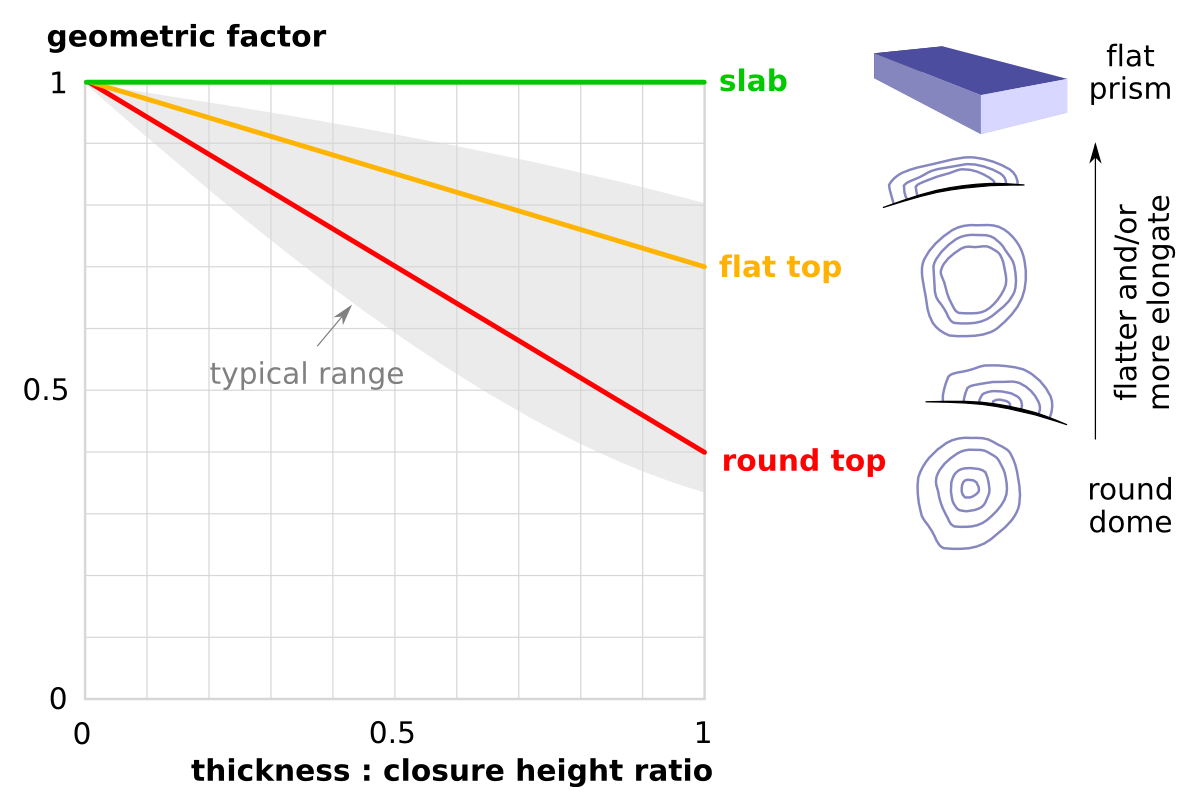

In [8]:
# Display an image file illustrating the Geometric Correction Factor
from IPython import display
display.Image("http://subsurfwiki.org/images/6/66/Geometric_correction_factor.png", width=600)

## 2. Key Inputs (Only alter the values in this section)

In [9]:
# GENERAL INPUT VARIABLES

n = 120000                   # number of samples or runs
seed = 121                   # fix the seed point - use RANDOM_STATE
bins = 500                    # number of bins
m3_to_bbl_conversion = 6.28981

# SPECIFIC INPUT VARIABLES

#1. AREA (meters^2)          TRIANGULAR DISTRIBUTION
a_min = 4100000              # scalar - Lower bound of the distribution support
a_max = 4250000              # scalar - Upper bound of the distribution support
c1 = 0.5                      # scalar - The location of the triangle's peak 

#2. THICKNESS (meters)      TRIANGULAR DISTRIBUTION
t_min = 70                   # scalar - Lower bound of the distribution support
t_max = 110                  # scalar - Upper bound of the distribution support 
c2 = 0.5                      # scalar - The location of the triangle's peak 

#3. NET-TO-GROSS (NTG)      TRIANGULAR DISTRIBUTION
ntg_min = 0.50               # scalar - Lower bound of the distribution support
ntg_max = 0.70               # scalar - Upper bound of the distribution support 
c3 = 0.5                      # scalar - The location of the triangle's peak

#4. POROSITY                 TRUNCATED NORMAL DISTRIBUTION
por_mean = 0.14              # Mean
por_std = 0.042              # Standard Deviation
por_lower = 0.00             # lower limit
por_upper = 1.00              # Upper limit

#5. WATER SATURATION         TRUNCATED NORMAL DISTRIBUTION
sw_mean = 0.25               # Mean
sw_std = 0.103               # Standard Deviation
sw_lower = 0.00              # lower limit
sw_upper = 1.00              # Upper limit

#6. OIL FORMATION VOLUME FACTOR (Bo)   UNIFORM DISTRIBUTION
bo_min = 1.03                # scalar - Lower bound of the distribution support
bo_max = bo_min+0.01         # scalar - Upper bound of the distribution support

#7. RECOVERY FACTOR (RF)     TRIANGULAR DISTRIBUTION
rf_min = 0.15                # scalar - Lower bound of the distribution support
rf_max = 0.35                # scalar - Upper bound of the distribution support 
c7 = 0.5                     # scalar - The location of the triangle's peak)

#8. GEOMETRIC CORRECTION FACTOR (g)   UNIFORM DISTRIBUTION
g_min = 0.76                 # scalar - Lower bound of the distribution support
g_max = g_min+0.04           # scalar - Upper bound of the distribution support 

## 3.  Probability Distributions - Random Number Generators

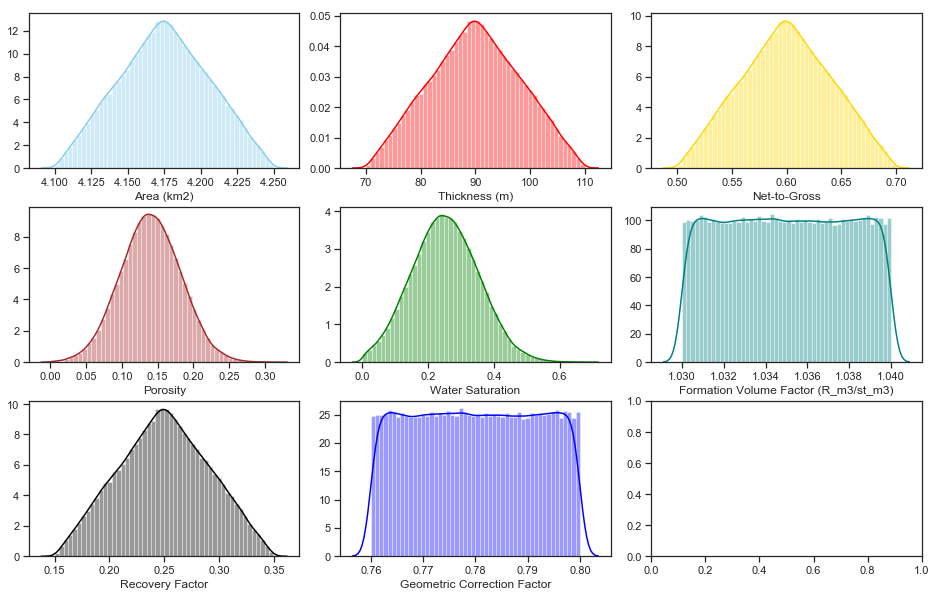

In [20]:
# Calculate Individual Probabilty Distributions using SciPy algorithms 
Area = stats.triang.rvs(c1, loc=a_min, scale=a_max-a_min, size=n, random_state = seed)
Thickness = stats.triang.rvs(c2, loc=t_min, scale=t_max-t_min, size=n, random_state = seed)
NTG = stats.triang.rvs(c3, loc=ntg_min, scale=ntg_max-ntg_min, size=n, random_state=seed)
# POR = stats.norm(por_mean, por_std).rvs(size = n, random_state=seed) 
POR = stats.truncnorm((por_lower - por_mean) / por_std, (por_upper - por_mean) / por_std, loc=por_mean, scale=por_std).rvs(size = n, random_state=seed) 
Sw = stats.truncnorm((sw_lower - sw_mean) / sw_std, (sw_upper - sw_mean) / sw_std, loc=sw_mean, scale=sw_std).rvs(size = n, random_state=seed) 
# Sw = stats.norm(sw_mean, sw_std).rvs(size = n, random_state=seed) 
Bo = stats.uniform.rvs(loc = bo_min, scale=bo_max-bo_min, size=n, random_state = seed)
RF = stats.triang.rvs(c7, loc=rf_min, scale=rf_max-rf_min, size=n, random_state=seed)
g = stats.uniform.rvs(loc = g_min, scale=g_max-g_min, size=n, random_state = seed)

# Plot Probability Distributions
sns.set(color_codes=True)
sns.set_style("ticks")
f, axes = plt.subplots(3, 3, figsize=(16, 10), )
f.subplots_adjust(hspace=0.25, wspace=0.15)
sns.distplot( Area/1e6, color="skyblue", ax=axes[0, 0], axlabel='Area (km2)')
sns.distplot( Thickness , color="red", ax=axes[0, 1], axlabel='Thickness (m)')
sns.distplot( NTG , color="gold", ax=axes[0, 2], axlabel='Net-to-Gross')
sns.distplot( POR , color="brown", ax=axes[1, 0], axlabel='Porosity')
sns.distplot( Sw , color="green", ax=axes[1, 1], axlabel='Water Saturation')
sns.distplot( Bo , color="teal", ax=axes[1, 2], axlabel='Formation Volume Factor (R_m3/st_m3)')
sns.distplot( RF , color="black", ax=axes[2, 0], axlabel='Recovery Factor')
sns.distplot( g , color="blue", ax=axes[2, 1], axlabel='Geometric Correction Factor')
plt.show()

## 4. STOIIP & Recoverable Resources Calculations 

In [21]:
GRV = g * Area * Thickness                                            # GRV in cubic meters
NRV = GRV * NTG                                                       # NRV in cubic meters
HCPV = NRV * POR * (1-Sw)                                             # HCPV in cubic meters
OIIP_m3 = HCPV / Bo                                                   # OIIP in cubic meters
OIIP = (GRV*NTG*POR*(1-Sw)* m3_to_bbl_conversion / 1E6) / Bo          # OIIP in mmbbls
Resources_m3 = OIIP_m3 * RF                                           # Recoverable Resources in cubic meters
Resources = OIIP * RF                                                 # Recoverable Resources in mmbbls

# Statistics
print("The minimum OIIP = %.1f mmbbls" % (min(OIIP)))
print("The maximum OIIP = %.1f mmbbls" % (max(OIIP)))
print("The mean OIIP = %.1f mmbbls" % (statistics.mean(OIIP)))                     # Arithmetic mean (“average”) of data
print("The OIIP std dev = %.1f mmbbls" % (statistics.stdev(OIIP)))                 # Sample standard deviation of data
print("The median OIIP = %.1f mmbbls" % (statistics.median(OIIP)))                 # Median (middle value) of data
print("The median_grouped OIIP = %.1f mmbbls" % (statistics.median_grouped(OIIP))) # Median or 50th percentile of grouped data
print("P99 OIIP = %.1f mmbbls" % (np.percentile(OIIP, 1))) 
print("P90 OIIP = %.1f mmbbls" % (np.percentile(OIIP, 10))) 
print("P50 OIIP = %.1f mmbbls" % (np.percentile(OIIP, 50))) 
print("P10 OIIP = %.1f mmbbls" % (np.percentile(OIIP, 90))) 
print("P01 OIIP = %.1f mmbbls" % (np.percentile(OIIP, 99)))

The minimum OIIP = 0.1 mmbbls
The maximum OIIP = 183.9 mmbbls
The mean OIIP = 111.7 mmbbls
The OIIP std dev = 36.5 mmbbls
The median OIIP = 112.0 mmbbls
The median_grouped OIIP = 111.5 mmbbls
P99 OIIP = 29.7 mmbbls
P90 OIIP = 62.7 mmbbls
P50 OIIP = 112.0 mmbbls
P10 OIIP = 161.1 mmbbls
P01 OIIP = 182.5 mmbbls


In [24]:
# Create and Display DataFrame Statistics
headers = ('Area (m2)','Thickness (m)','NTG','Porosity','Sw','Bo (m3/m3)','GRV (m3)','NRV (m3)','HCPV (m3)','OIIP (m3)','OIIP (mmbo)')
data = [Area, Thickness, NTG, POR, Sw, Bo, GRV, NRV, HCPV, OIIP_m3, OIIP]
data_dict = dict(zip(headers, data))
df = pd.DataFrame(data_dict)
df.describe()

,Area (m2),Thickness (m),NTG,Porosity,Sw,Bo (m3/m3),GRV (m3),NRV (m3),HCPV (m3),OIIP (m3),OIIP (mmbo)
count,1.200000e+05,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,1.200000e+05,1.200000e+05,1.200000e+05,1.200000e+05,120000.000000
mean,4.175033e+06,90.008789,0.600044,0.140122,0.252310,1.035002,2.937364e+08,1.776070e+08,1.839048e+07,1.775249e+07,111.659759
std,3.065585e+04,8.174894,0.040874,0.041959,0.100482,0.002890,3.309433e+07,3.195497e+07,6.063324e+06,5.810118e+06,36.544539
min,4.100257e+06,70.068606,0.500343,0.000159,0.000029,1.030000,2.183475e+08,1.092487e+08,1.738587e+04,1.687949e+04,0.106169
25%,4.153081e+06,84.154868,0.570774,0.111773,0.182509,1.032505,2.691228e+08,1.536084e+08,1.403577e+07,1.359391e+07,85.503085
50%,4.174953e+06,89.987441,0.599937,0.139957,0.250821,1.034994,2.930314e+08,1.758004e+08,1.843310e+07,1.780987e+07,112.020696
75%,4.197151e+06,95.906862,0.629534,0.168572,0.320650,1.037517,3.180309e+08,2.002114e+08,2.292805e+07,2.209896e+07,138.998245
max,4.249648e+06,109.906123,0.699531,0.318220,0.687229,1.040000,3.736497e+08,2.613794e+08,3.040752e+07,2.923919e+07,183.908931


In [25]:
# Quantile Statistics
df.describe().quantile([.01, .1, .25, .5, .75, .9, .99])

,Area (m2),Thickness (m),NTG,Porosity,Sw,Bo (m3/m3),GRV (m3),NRV (m3),HCPV (m3),OIIP (m3),OIIP (mmbo)
0.01,3.690994e+04,12.507454,0.073037,0.003085,0.007060,0.074787,2.428203e+06,2.348448e+06,2.456886e+04,2.409792e+04,2.656855
0.10,9.319676e+04,51.500493,0.362502,0.029419,0.070346,0.721867,2.320203e+07,2.240448e+07,8.921576e+04,8.906385e+04,25.613028
0.25,3.105193e+06,80.633303,0.553167,0.094320,0.162002,1.031878,1.720342e+08,8.992525e+07,4.577493e+06,4.387589e+06,73.263449
0.50,4.164017e+06,89.998115,0.599991,0.140039,0.251566,1.034998,2.810771e+08,1.647044e+08,1.621312e+07,1.567320e+07,111.840228
0.75,4.180562e+06,99.406677,0.647033,0.205984,0.412295,1.038138,2.998100e+08,1.832581e+08,1.955684e+07,1.888214e+07,150.225916
0.90,4.212900e+06,36076.934286,36000.489671,36000.222754,36000.481060,36000.728000,3.347166e+08,2.185618e+08,2.517189e+07,2.424103e+07,36128.736252
0.99,4.245973e+06,111607.693429,111600.048967,111600.022275,111600.048106,111600.072800,3.697563e+08,2.570976e+08,2.988396e+07,2.873937e+07,111612.873625


In [26]:
# Export Volumetrics Data to a CSV file
pd.DataFrame(df).to_csv("D:/Oil and Gas/OIIP.csv")

## 5. Cumulative Distribution Function (CDF)

### Using histograms to plot a cumulative distribution

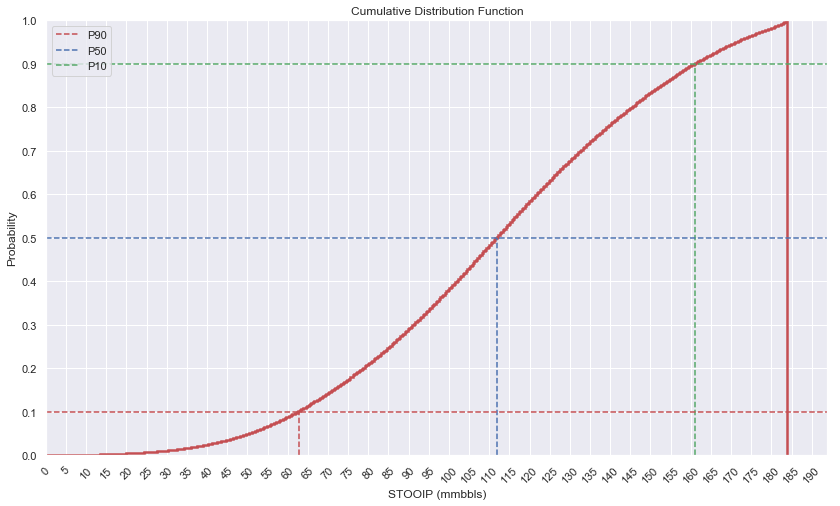

In [30]:
# PLot Cumulative Distribution Function
sns.set_style("ticks")
sns.set(color_codes=True)
fig = plt.figure(figsize=(14,8))
plt.ylabel('Probability')
plt.xlabel('STOOIP (mmbbls)')
plt.title('Cumulative Distribution Function')
plt.xlim(min(OIIP), max(OIIP)+10)
plt.xticks(rotation=45)
plt.ylim(0.0,1.0)
plt.locator_params(axis='x', nbins=40)
plt.locator_params(axis='y', nbins=10)
plt.grid(True)
plt.axvline(x=np.percentile(OIIP, 10), ymax=0.1, color='r', linestyle='--', label='P90')
plt.axvline(x=np.percentile(OIIP, 50), ymax=0.5, color='b', linestyle='--', label='P50')
plt.axvline(x=np.percentile(OIIP, 90), ymax=0.9, color='g', linestyle='--', label='P10')
plt.axhline(y=0.1, xmax=np.percentile(OIIP, 10), color='r', linestyle='--')
plt.axhline(y=0.5, xmax=np.percentile(OIIP, 50), color='b', linestyle='--')
plt.axhline(y=0.9, xmax=np.percentile(OIIP, 90), color='g', linestyle='--')
# Plot the data
cdf_plot = plt.hist(OIIP, bins=bins, density=True, cumulative=True, histtype='step', linewidth=2.5, color='r')
plt.legend(loc=2)
plt.show()

## 6. Probability Distribution Function (PDF)

### Using Gaussian KDE

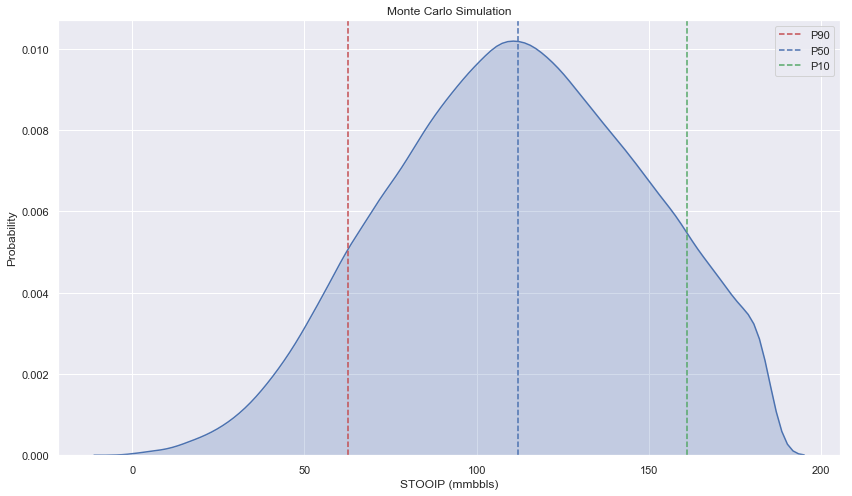

In [31]:
sns.set_style("ticks")
sns.set(color_codes=True)
fig = plt.figure(figsize=(14,8))
ax=sns.kdeplot(OIIP, shade=True)
plt.axvline(x=np.percentile(OIIP, 10), color='r', linestyle='--', label='P90')
plt.axvline(x=np.percentile(OIIP, 50), color='b', linestyle='--', label='P50')
plt.axvline(x=np.percentile(OIIP, 90), color='g', linestyle='--', label='P10')
plt.ylabel('Probability')
plt.xlabel('STOOIP (mmbbls)')
plt.title('Monte Carlo Simulation')
plt.legend()
plt.show()

To figure out which other SciPy probability distributions can be used, below is a useful link.

In [52]:
from IPython.core.display import HTML
HTML('http://cmdlinetips.com/2018/03/probability-distributions-in-python/')